In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost 
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
#from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
import glob
brand_dict = dict()
path = "Datasets/*_features.csv"
for fname in glob.glob(path):
    brand = fname.split('/')[1].split('_')[0]
    brand_dict[brand] = pd.read_csv(fname)
    brand_dict[brand].dropna(inplace=True)

In [3]:
brand_dict["Carters"].sort_values(by="Date", inplace=True)
X = brand_dict["Carters"][['avg_comments', 'avg_bookmarks', 'avg_shares',
       'year', 'month', 'day', 'weekday', 'avg_discount', 
        'discount_past1day', 'discount_past2day',
       'discount_past3day', 'discount_past4day', 'discount_past5day',
       'discount_past6day', 'discount_past7day', 'discount_min_past15day',
       'discount_min_past30day', 'discount_max_past15day',
       'discount_max_past30day', 'discount_mean_past15day',
       'discount_mean_past30day', 'nday_away_Martin_Luther_King_Jr_Day',
       'nday_away_New_Years_Day', 'nday_away_Memorial_Day',
       'nday_away_Columbus_Day', 'nday_away_Veterans_Day',
       'nday_away_Independence_Day', 'nday_away_Labor_Day',
       'nday_away_Washingtons_Birthday', 'nday_away_Thanksgiving',
       'nday_away_Christmas_Day', 'nday_away_anyholiday']]

### Now move on to multi-class classification--How extreme the discount would be within 3 days (no deal, 20%off, 30%off,...or 70%off)?


[50  0 30 60 20 40 70 80]


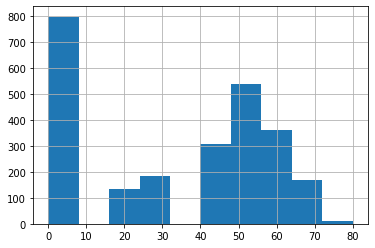

In [4]:
print(brand_dict["Carters"]["Y_avg_discount_3d"].unique())
brand_dict["Carters"]["Y_avg_discount_3d"].hist()

In [5]:
brand_dict["Carters"]['label'] = 0
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 20, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 30, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 40, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 50, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 60, 'label'] = 2
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 70, 'label'] = 2
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 80, 'label'] = 2
condition1a = brand_dict["Carters"]['Y_avg_discount_3d'] >= 10
condition1b = brand_dict["Carters"]['Y_avg_discount_3d'] <= 55
condition2a = brand_dict["Carters"]['Y_avg_discount_3d'] >= 56
condition2b = brand_dict["Carters"]['Y_avg_discount_3d'] <= 95
print("10 -- 50%")
print(brand_dict["Carters"].loc[condition1a & condition1b, 'Y_avg_discount_3d'].mean() )
print(brand_dict["Carters"].loc[condition1a & condition1b, 'Y_avg_discount_3d'].std() )
print('\n')
print("56 -- 95%")
print(brand_dict["Carters"].loc[condition2a & condition2b, 'Y_avg_discount_3d'].mean() )
print(brand_dict["Carters"].loc[condition2a & condition2b, 'Y_avg_discount_3d'].std() )

10 -- 50%
40.705073086844365
10.405787482939196


56 -- 95%
63.54359925788497
5.232818480680022


In [6]:
y = brand_dict["Carters"]['label']

In [7]:
X_lastday, y_lastday = X.iloc[-1:, ], y.iloc[-1:, ]
X,y = X.iloc[0:-1, ], y.iloc[0:-1, ]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#X_train, X_validate, X_test = np.split(X.sample(frac=1), [int(.8*len(X)), int(.9*len(X))])
#y_train, y_validate, y_test = np.split(y.sample(frac=1), [int(.8*len(y)), int(.9*len(y))])

In [8]:
print(X_lastday)
print("\n")
print(y_lastday)

      avg_comments  avg_bookmarks  avg_shares  year  month  day  weekday  \
2529           0.0            0.0         0.0  2020      1   18        5   

      avg_discount  discount_past1day  discount_past2day  ...  \
2529           0.0                0.0                1.0  ...   

      nday_away_New_Years_Day  nday_away_Memorial_Day  nday_away_Columbus_Day  \
2529                 0.519271            7.330320e-17            8.397145e-10   

      nday_away_Veterans_Day  nday_away_Independence_Day  nday_away_Labor_Day  \
2529                0.000028                1.603811e-28         1.760228e-19   

      nday_away_Washingtons_Birthday  nday_away_Thanksgiving  \
2529                        0.129923                0.002745   

      nday_away_Christmas_Day  nday_away_anyholiday  
2529                 0.270868              0.990971  

[1 rows x 32 columns]


2529    2
Name: label, dtype: int64


First, try Logistic Regression as Baseline Model

In [9]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.4860606060606061


/Users/universebright/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [10]:
y_hat_train = logisticRegr.predict(X_train)
y_hat_test = logisticRegr.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)
plt.figure(1)
y_pred_prob = logisticRegr.predict_proba(X_test)[:, 1]
#fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_prob)
#plt.plot(fpr_grd,tpr_grd)
#auc(fpr_grd,tpr_grd)

              precision    recall  f1-score   support

           0       0.54      0.38      0.45       532
           1       0.52      0.77      0.62       789
           2       0.57      0.22      0.32       353

    accuracy                           0.53      1674
   macro avg       0.54      0.46      0.46      1674
weighted avg       0.54      0.53      0.50      1674

              precision    recall  f1-score   support

           0       0.49      0.40      0.44       266
           1       0.48      0.71      0.57       374
           2       0.56      0.16      0.25       185

    accuracy                           0.49       825
   macro avg       0.51      0.42      0.42       825
weighted avg       0.50      0.49      0.46       825

Confusion Matrix:
[[204 314  14]
 [141 604  44]
 [ 35 241  77]]
[[107 153   6]
 [ 92 264  18]
 [ 20 135  30]]


<Figure size 432x288 with 0 Axes>

Next try XGBoost model

In [11]:
xgb = XGBClassifier(random_state=2)
xgb.fit(X_train, np.array(y_train))
xgb.score(X_test,y_test)

0.5915151515151515

In [12]:
y_hat_train = xgb.predict(X_train)
y_hat_test = xgb.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)

plt.figure(1)
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
#fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_prob)
#plt.plot(fpr_grd,tpr_grd)
#auc(fpr_grd,tpr_grd)

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       532
           1       0.72      0.86      0.78       789
           2       0.79      0.57      0.66       353

    accuracy                           0.75      1674
   macro avg       0.76      0.71      0.73      1674
weighted avg       0.75      0.75      0.74      1674

              precision    recall  f1-score   support

           0       0.55      0.51      0.53       266
           1       0.60      0.74      0.66       374
           2       0.67      0.42      0.51       185

    accuracy                           0.59       825
   macro avg       0.60      0.55      0.57       825
weighted avg       0.60      0.59      0.58       825

Confusion Matrix:
[[366 147  19]
 [ 72 681  36]
 [ 32 119 202]]
[[135 121  10]
 [ 70 276  28]
 [ 42  66  77]]


<Figure size 432x288 with 0 Axes>

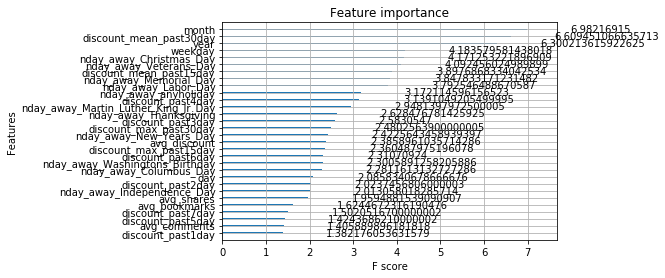

In [13]:
plot_importance(xgb, importance_type='gain')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [32]:
estimator = XGBClassifier(
    objective= 'multi:softmax',
    nthread=4,
    seed=42,
    num_class=3,
)

In [33]:
 parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1_macro', # or 'f1_micro', ‘f1_weighted’
    n_jobs = 10,
    cv = 5,
    verbose=True
)
grid_search.fit(X_test, y_test)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:  3.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, num_class=3,
                                     objective='multi:softmax', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                       

In [34]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)

In [35]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)
xgb.fit(X_train, np.array(y_train))
xgb.score(X_test, y_test)

0.6654545454545454

In [25]:
y_hat_train = xgb.predict(X_train)
y_hat_test = xgb.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)

plt.figure(1)
y_pred_prob = xgb.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       532
           1       1.00      1.00      1.00       789
           2       1.00      1.00      1.00       353

    accuracy                           1.00      1674
   macro avg       1.00      1.00      1.00      1674
weighted avg       1.00      1.00      1.00      1674

              precision    recall  f1-score   support

           0       0.62      0.59      0.61       266
           1       0.67      0.78      0.72       374
           2       0.72      0.55      0.63       185

    accuracy                           0.67       825
   macro avg       0.67      0.64      0.65       825
weighted avg       0.67      0.67      0.66       825

Confusion Matrix:
[[532   0   0]
 [  0 789   0]
 [  0   0 353]]
[[157  95  14]
 [ 59 290  25]
 [ 37  46 102]]


<Figure size 720x720 with 0 Axes>

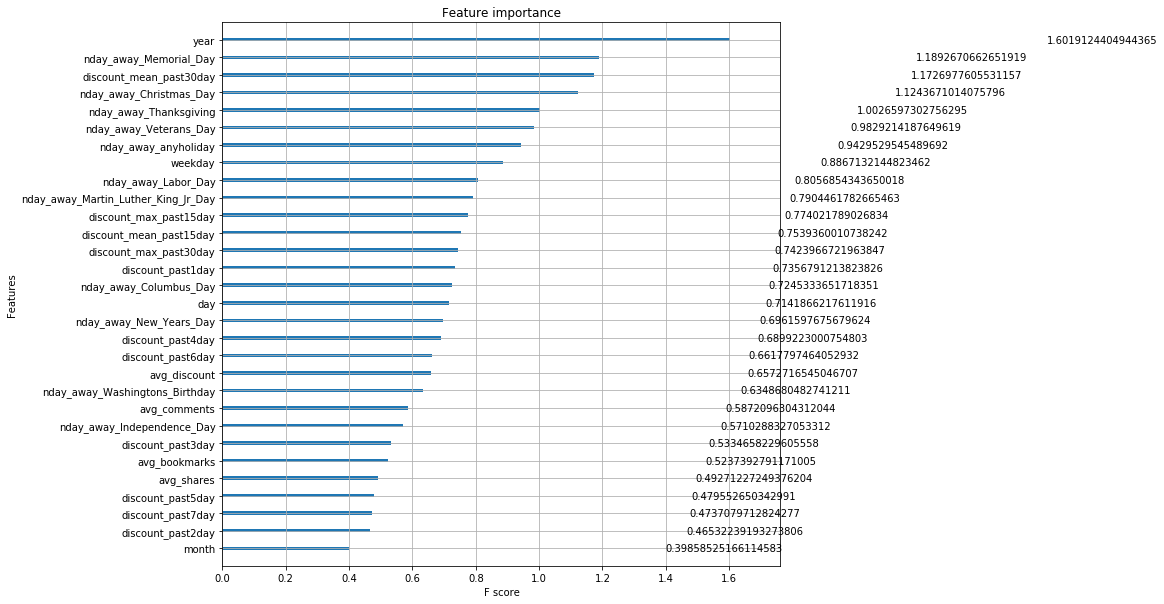

In [36]:
plot_importance(xgb, importance_type='gain')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [38]:
y_hat_lastday = xgb.predict(X_lastday)
y_hat_lastday

array([2])